In [1]:
import os
import numpy as np
import pandas as pd 
import glob
import shap
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, LassoCV, ElasticNetCV
os.chdir('/mnt/BioHome/jreyna/jreyna/projects/cmi-pb-preds/')

# setting the data directory
data_dir = 'results/main/cmi_pb_datasets/processed/harmonized/'

# setting the output dir
output_dir = 'results/main/submissions/jive_models/'
os.makedirs(output_dir, exist_ok=True)

/mnt/BioHome/jreyna/jreyna/software/mambaforge/envs/hichip-db/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_dict = {'lr': LinearRegression, 
              'lasso': Lasso,
              'elastic_net': ElasticNet, 
              'lasso_cv': LassoCV,
              'elastic_net_cv': ElasticNetCV}

In [3]:
cmodel = 'lr'
cmodel = 'lasso'
cmodel = 'elastic_net'
cmodel = 'lasso_cv'
cmodel = 'elastic_net_cv'
cmodel_function = model_dict[cmodel]

## Loading the loading matrices

In [4]:
loadings = {} 
tpl = '/mnt/BioAdHoc/Groups/vd-ay/jreyna/projects/cmi-pb-momix/results/factors/*.loading.tsv'
for loading_fn in glob.glob(tpl):
    
    bn = os.path.basename(loading_fn)
    assay = bn.split('.')[0]
    loadings_matrix = pd.read_table(loading_fn)
    loadings[assay] = loadings_matrix

## Listing the shared subjects

In [5]:
# # get the shared subjects 
# shared_subjects = rnaseq_raw.columns.tolist()
# shared_subjects = [int(x.replace('X', '')) for x in shared_subjects]
shared_subjects = [4, 6, 11, 15, 20, 21, 26, 31, 33, 44, 47, 48, 52]

## Loading the input data

In [6]:
# setting up dictionaries to load data and results
train_features = {}
train_outcomes = {}

test_features = {}
test_preds = {}

#### Training Features (calculating the reduce form of each omic)

In [7]:
tpl = '/mnt/BioAdHoc/Groups/vd-ay/jreyna/projects/cmi-pb-momix/'
tpl += 'results/input_data/*.2020.momix.day0.input.tsv.harmonized.tsv'
for raw_fn in glob.glob(tpl):  
    
    bn = os.path.basename(raw_fn)
    assay = bn.split('.')[0]
    
    # Loading the raw matrices
    raw = pd.read_table(raw_fn, index_col=0, header=0)
    
    ## Calculating the sample factor matrix
    raw_array = np.matrix(raw.T.values)
    loadings_array = np.matrix(loadings[assay].values)
    sample_factors = raw_array * loadings_array
    train_features[assay] = pd.DataFrame(sample_factors) 
    train_features[assay].index = raw.columns.str.replace('X', '').astype(int)

In [31]:
glob.glob(tpl)

['results/main/cmi_pb_datasets/processed/harmonized/abtiters.mfi_normalised.2021.day0.pivoted.tsv',
 'results/main/cmi_pb_datasets/processed/harmonized/cytof.2021.day0.pivoted.tsv',
 'results/main/cmi_pb_datasets/processed/harmonized/olink.2021.day0.pivoted.tsv',
 'results/main/cmi_pb_datasets/processed/harmonized/abtiters.mfi_raw.2021.day0.pivoted.tsv',
 'results/main/cmi_pb_datasets/processed/harmonized/rnaseq.2021.day0.pivoted.tsv']

In [8]:
train_features[assay]

,0,1,2,3,4,5,6,7,8,9
4,18.501266,18.816058,-3.279093,8.135793,3.220009,3.029462,-6.892040,2.201627,-4.153506,-8.720384
6,24.609332,38.022989,-8.853925,14.840321,0.536037,2.142527,-8.789163,2.527824,-5.320153,-6.777567
11,52.172205,50.884542,-6.887389,15.646211,9.970164,1.971205,-14.224462,2.914185,-5.097582,-11.581859
15,25.577545,33.840872,-5.116219,16.841497,5.816615,6.939347,-4.275021,5.662264,-8.614458,-15.359694
20,12.453402,24.184701,-4.786949,14.515380,-5.250020,6.674168,-9.978196,3.028039,-7.871834,-10.947127
21,11.587124,20.975921,-5.558505,12.942014,-2.596880,4.145574,-8.852224,3.371696,-5.715736,-10.812218
26,57.019845,48.079507,-9.394332,13.408658,11.035178,1.233398,-21.595454,0.806174,-7.564238,-15.049903
31,50.425130,46.104916,-4.293778,16.503302,13.496684,4.615812,-11.364364,5.498322,-4.111305,-16.786310
33,34.069801,33.434131,-7.800893,15.008086,7.400679,1.936668,-11.309345,5.314118,-6.536328,-15.405857
44,19.944982,34.438522,-7.527921,13.609578,1.174292,3.956342,-7.418634,1.702294,-4.243962,-6.407255


In [9]:
train_features['final'] = pd.concat([train_features['cytof'], train_features['olink'], train_features['rnaseq']], axis=1)

In [10]:
train_features['final']

,0,1,2,3,4,5,6,7,8,9,...,0,1,2,3,4,5,6,7,8,9
4,18.501266,18.816058,-3.279093,8.135793,3.220009,3.029462,-6.892040,2.201627,-4.153506,-8.720384,...,-4027.395473,3470.278294,-3164.722691,4402.980371,5073.610276,-3892.017960,9197.172158,-3889.231413,4762.106130,1914.052108
6,24.609332,38.022989,-8.853925,14.840321,0.536037,2.142527,-8.789163,2.527824,-5.320153,-6.777567,...,-7694.804155,8809.059977,-7856.745104,4674.646648,5980.813585,-5620.970280,10803.205709,-5438.147168,6390.215962,2172.551774
11,52.172205,50.884542,-6.887389,15.646211,9.970164,1.971205,-14.224462,2.914185,-5.097582,-11.581859,...,-3650.049242,5188.642002,-3595.217020,4991.843631,3262.330491,-6251.516829,10074.695970,-4945.532206,4322.081167,2151.388233
15,25.577545,33.840872,-5.116219,16.841497,5.816615,6.939347,-4.275021,5.662264,-8.614458,-15.359694,...,-7700.376350,6570.496410,-4900.737756,5411.270058,5648.303522,-6610.346402,8897.277772,-4884.259427,4513.443262,-29.343774
20,12.453402,24.184701,-4.786949,14.515380,-5.250020,6.674168,-9.978196,3.028039,-7.871834,-10.947127,...,-5521.089057,3480.372010,-2446.570315,7437.423017,2824.305178,-3539.952476,4673.832210,-5126.497022,7034.088140,1522.442667
21,11.587124,20.975921,-5.558505,12.942014,-2.596880,4.145574,-8.852224,3.371696,-5.715736,-10.812218,...,-9680.896055,6303.130749,-5043.143766,5171.776211,7114.735375,-6273.669270,8436.363283,-4343.640211,4997.923165,-878.890662
26,57.019845,48.079507,-9.394332,13.408658,11.035178,1.233398,-21.595454,0.806174,-7.564238,-15.049903,...,-1762.474200,4456.083037,-4656.021104,4760.160133,3017.480411,-3950.449351,10231.932954,-5372.350260,5557.139811,2978.995679
31,50.425130,46.104916,-4.293778,16.503302,13.496684,4.615812,-11.364364,5.498322,-4.111305,-16.786310,...,-2252.744570,3830.033266,-4271.984619,5256.376294,3981.507902,-2888.945472,9870.946013,-4401.013575,6568.707462,2750.604970
33,34.069801,33.434131,-7.800893,15.008086,7.400679,1.936668,-11.309345,5.314118,-6.536328,-15.405857,...,-4896.360183,4614.238071,-5272.109758,6300.603736,5625.017362,-3740.059241,8893.736220,-4661.053740,6842.548347,2454.976267
44,19.944982,34.438522,-7.527921,13.609578,1.174292,3.956342,-7.418634,1.702294,-4.243962,-6.407255,...,-11694.977017,9533.341845,-7778.668270,5608.081254,8227.010211,-5608.294793,6026.918241,-5760.060499,6854.529859,1121.038707


#### Training Outcomes

In [11]:
fn = os.path.join(data_dir, 'task_matrix.common_names.mfi_normalised.tsv')
train_outcomes = pd.read_table(fn)
train_outcomes = train_outcomes.loc[train_outcomes.subject_id.isin(shared_subjects)]

In [12]:
train_outcomes.shape

(13, 15)

#### Testing Features

In [13]:
test_features = {} 
shared_subjects_2021 = set()
tpl = 'results/main/cmi_pb_datasets/processed/harmonized/*.2021.day0.pivoted.tsv'

i = 0 
for raw_fn in glob.glob(tpl):  
    
    # get the assay name
    bn = os.path.basename(raw_fn)
    assay = bn.split('.')[0]
    
    if assay in ['abtiters']:
        continue
    
    print(raw_fn)
    print(assay)
    
    # loading the raw matrices
    raw = pd.read_table(raw_fn, index_col=0, header=0)
    
    print(raw.shape)
    
    raw = raw.loc[:, raw.columns.isin(loadings[assay].index)]
    
    print(raw.shape)
    
    # getting the loadings matrix 
        
    ## Calculating the sample factor matrix
    raw_array = np.matrix(raw.values)
    loadings_array = np.matrix(loadings[assay].values)
    sample_factors = raw_array * loadings_array
    
    # add to the test_features dict 
    test_features[assay] = pd.DataFrame(sample_factors)
    test_features[assay].index = raw.index
    
    
    if i == 0:
        shared_subjects_2021 = set(test_features[assay].index)
    else:
        shared_subjects_2021 = shared_subjects_2021.intersection(test_features[assay].index)
    i += 1 


results/main/cmi_pb_datasets/processed/harmonized/cytof.2021.day0.pivoted.tsv
cytof
(33, 22)
(33, 21)
results/main/cmi_pb_datasets/processed/harmonized/olink.2021.day0.pivoted.tsv
olink
(36, 27)
(36, 23)
results/main/cmi_pb_datasets/processed/harmonized/rnaseq.2021.day0.pivoted.tsv
rnaseq
(36, 11589)
(36, 11589)


In [14]:
# harmonize the samples
for assay in test_features.keys():
    test_features[assay] =  test_features[assay].loc[test_features[assay].index.isin(shared_subjects_2021), :]

In [15]:
test_features['final'] = pd.concat([test_features['cytof'], test_features['olink'], test_features['rnaseq']], axis=1)
test_features['final'] = test_features['final'].dropna()

In [16]:
test_features['final']

,0,1,2,3,4,5,6,7,8,9,...,0,1,2,3,4,5,6,7,8,9
subject_id,,,,,,,,,,,,,,,,,,,,,
63,44.696430,41.690035,-7.214139,23.240366,2.136601,12.748282,-22.850137,4.154680,-17.358799,-28.783088,...,-24198.611508,16641.592266,-16105.339212,7809.653192,12583.973239,-9183.781067,4507.451777,-5874.798718,9232.008984,-851.385512
64,27.856438,28.321223,-4.733470,22.713538,0.427908,6.562069,-11.011902,11.134754,-11.759368,-24.541905,...,-20716.746505,13193.792111,-13970.507479,5927.462313,12586.635282,-7826.377853,6122.863495,-3018.074077,7044.278269,-1310.331764
65,39.005592,37.369216,-9.295215,19.400767,-0.162314,8.435066,-23.237163,3.074196,-16.716408,-24.527929,...,-31886.823701,23034.444879,-20589.033015,6896.435240,17575.944583,-10886.897584,7114.882771,-6938.423594,8402.858284,-3813.840449
66,38.723471,39.569805,-4.562110,26.169709,-1.282023,11.690512,-18.911311,9.955194,-16.342605,-30.426337,...,-38865.544701,19261.950517,-11031.164992,16907.732696,9444.673664,-23515.232787,-11203.361272,-7519.303804,9564.115349,-10028.204476
67,25.023606,38.446371,-10.840939,17.853650,-7.507952,9.611313,-20.515549,-1.742217,-16.074133,-14.301677,...,-45672.895004,28402.520941,-21145.572672,13396.549258,15655.903522,-22067.066800,-3785.931689,-9996.543005,10098.653913,-9590.682143
68,44.522318,39.178696,-8.926077,20.901548,0.434296,9.260969,-25.870116,3.743994,-18.201845,-27.759923,...,-18221.687726,12525.742739,-15274.545218,6134.487140,10470.131598,-6089.268631,5755.027130,-3234.539895,8445.806890,248.238093
69,45.986040,42.091344,-6.032890,23.923080,1.148144,12.244099,-24.006706,6.468073,-16.674462,-30.104523,...,-22749.560879,14822.906248,-14121.552907,8984.465515,10145.187312,-8837.515832,198.092263,-4837.286619,9379.026422,-376.944846
71,40.904771,36.057161,-10.032878,19.699004,2.231635,7.131895,-24.470696,4.410395,-13.204925,-26.294748,...,-18966.645591,11632.358761,-12901.371958,8902.279381,10318.734066,-8122.708136,6216.983779,-5418.033784,9460.780788,710.752771
72,21.925830,29.115880,-7.804056,17.471738,-0.839963,9.088636,-11.989895,3.045577,-16.415086,-19.279431,...,-27299.091561,14649.032377,-12176.840075,13720.622507,7789.541965,-14294.473048,-5795.951990,-5570.025931,10706.272286,-3892.644630


## Building Lists of Tasks Cased on Assay Type

In [17]:
abtiter_tasks = ['IgG-PT_day14', 'IgG-FHA_day14', 'IgG-PRN_day14']
cytof_tasks = ['Monocytes_day1', 'ASCs (Plasmablasts)_day7', 'CD4Tcells_day3']
rnaseq_tasks = ['CCL3_day3', 'IL-6_day3', 'NFKBIA_day7', 'XIST_day14']

## Make predictions for the Ab Titers

In [18]:
ctrain_features = train_features['final']
ctest_features = test_features['final']

IgG-PT_day14


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.810e-02, tolerance: 4.677e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.197e-02, tolerance: 4.677e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.029e-02, tolerance: 4.677e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.241e-01, tolerance: 4.393e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.150e-01, tolerance: 4.393e-02
Objective did n

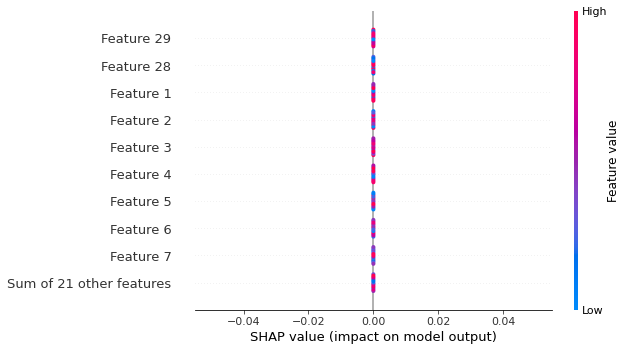

IgG-FHA_day14


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.139e+00, tolerance: 9.747e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.701e-01, tolerance: 9.747e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.676e-01, tolerance: 9.747e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.634e-01, tolerance: 9.747e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.586e-01, tolerance: 9.747e-02
Objective did n

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.067e-01, tolerance: 1.038e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.300e-01, tolerance: 1.038e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.294e-01, tolerance: 1.038e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.278e-01, tolerance: 1.038e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.254e-01, tolerance: 1.038e-01
Objective did n

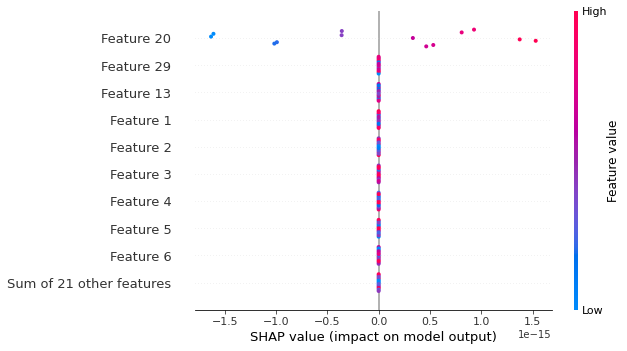

IgG-PRN_day14


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.972e-02, tolerance: 3.910e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.504e-01, tolerance: 3.910e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.517e-01, tolerance: 3.910e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.452e-01, tolerance: 3.910e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.382e-01, tolerance: 3.910e-02
Objective did n

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.025e+00, tolerance: 3.926e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.159e+00, tolerance: 3.926e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.266e+00, tolerance: 3.926e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.348e+00, tolerance: 3.926e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.408e+00, tolerance: 3.926e-02
Objective did n

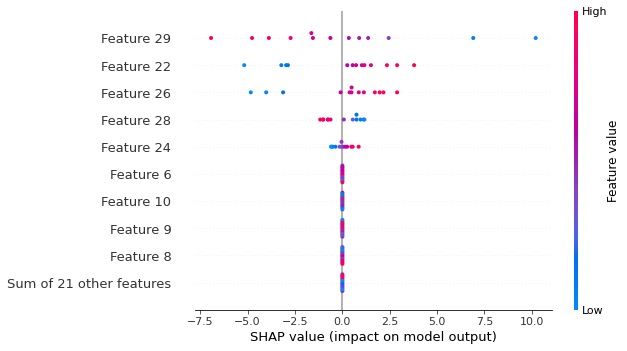

In [28]:
for task in abtiter_tasks:
    
    print(task)

    # get the outcome vector 
    ctrain_outcome = train_outcomes[['subject_id', task]]
    
    # get the shared subjects 
    shared_subjects = set(ctrain_features.index.tolist()).intersection(ctrain_outcome.subject_id)
 
    # extract the shared subjects  
    xdata = ctrain_features.loc[ctrain_features.index.isin(shared_subjects)]
    ydata = ctrain_outcome.loc[ctrain_outcome.subject_id.isin(shared_subjects)]      
    
    # building the model
    lr_model = cmodel_function()
    lr_model.fit(xdata.values, ydata.iloc[:, 1].values)
    preds = lr_model.predict(ctest_features.values)
    
    # create the explanations 
    # explain the model's predictions using SHAP
    explainer = shap.explainers.Linear(lr_model, xdata.values)
    shap_values = explainer(xdata.values)
    shap.plots.beeswarm(shap_values)#, X_test_array, feature_names=vectorizer.get_feature_names())
    
    #     # create the ranks df
    #     ranks = [ctest_features.index.tolist(), np.argsort(preds)]
    #     ranks = list(zip(*ranks))
    #     ranks = pd.DataFrame(ranks, columns=['subject_id', 'rank'])
    
    test_preds[task] = shap_values
    

## Make predictions for the CyTOF

Monocytes_day1


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.110e-01, tolerance: 8.795e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.836e-01, tolerance: 8.795e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.602e-01, tolerance: 1.493e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.925e-01, tolerance: 1.493e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.079e+00, tolerance: 1.493e-01
Objective did n

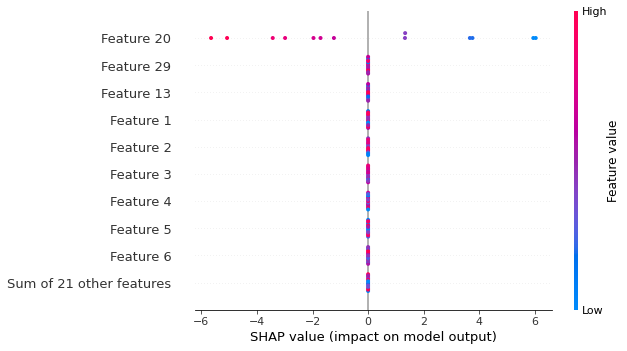

ASCs (Plasmablasts)_day7


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.705e-03, tolerance: 1.148e-03
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.801e-03, tolerance: 1.148e-03
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.860e-03, tolerance: 1.148e-03
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.595e-03, tolerance: 1.148e-03
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.297e-03, tolerance: 1.148e-03
Objective did n

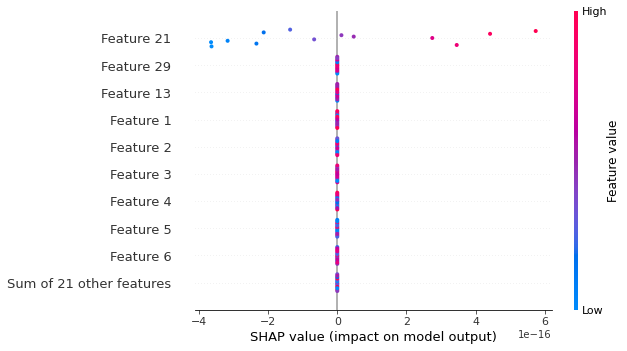

CD4Tcells_day3


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.466e+00, tolerance: 2.159e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.535e+00, tolerance: 2.159e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.925e+00, tolerance: 2.159e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.280e+00, tolerance: 2.159e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.314e+00, tolerance: 2.159e-01
Objective did n

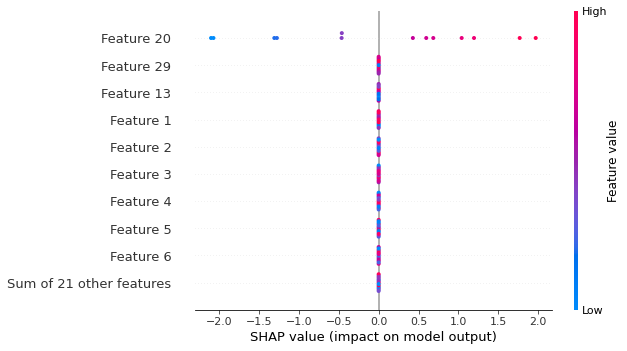

In [29]:
for task in cytof_tasks:
    
    print(task)

    # get the outcome vector 
    ctrain_outcome = train_outcomes[['subject_id', task]]
    
    # get the shared subjects 
    shared_subjects = set(ctrain_features.index.tolist()).intersection(ctrain_outcome.subject_id)
 
    # extract the shared subjects  
    xdata = ctrain_features.loc[ctrain_features.index.isin(shared_subjects)]
    ydata = ctrain_outcome.loc[ctrain_outcome.subject_id.isin(shared_subjects)]   
        
    # building the model
    lr_model = cmodel_function()
    lr_model.fit(xdata.values, ydata.iloc[:, 1].values)
    preds = lr_model.predict(ctest_features.values)
    
    # create the explanations 
    # explain the model's predictions using SHAP
    explainer = shap.explainers.Linear(lr_model, xdata.values)
    shap_values = explainer(xdata.values)
    shap.plots.beeswarm(shap_values)#, X_test_array, feature_names=vectorizer.get_feature_names())
    
    #     # create the ranks df
    #     ranks = [ctest_features.index.tolist(), np.argsort(preds)]
    #     ranks = list(zip(*ranks))
    #     ranks = pd.DataFrame(ranks, columns=['subject_id', 'rank'])
    #     test_preds[task] = ranks

## Make predictions for the RNA-seq based tasks

In [143]:
ctrain_features = train_features['rnaseq']
ctest_features = test_features['rnaseq']

CCL3_day3


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.453e+02, tolerance: 1.641e+02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.042e+02, tolerance: 1.641e+02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.332e+02, tolerance: 1.641e+02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.252e+02, tolerance: 1.641e+02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.940e+02, tolerance: 1.641e+02
Objective did n

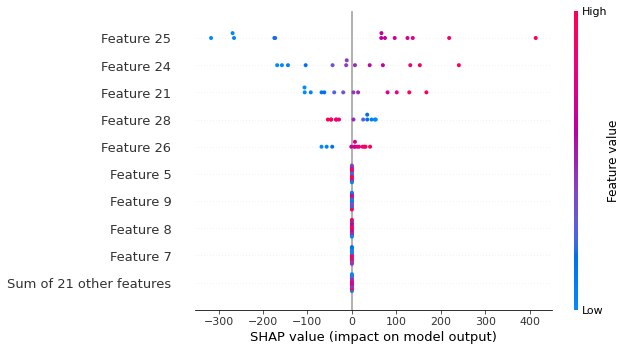

IL-6_day3


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.162e+01, tolerance: 2.354e+01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.611e+01, tolerance: 2.354e+01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.916e+01, tolerance: 2.354e+01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.135e+01, tolerance: 2.354e+01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.343e+01, tolerance: 2.354e+01
Objective did n

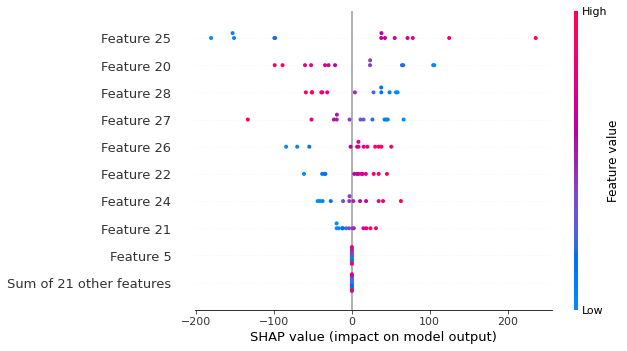

NFKBIA_day7


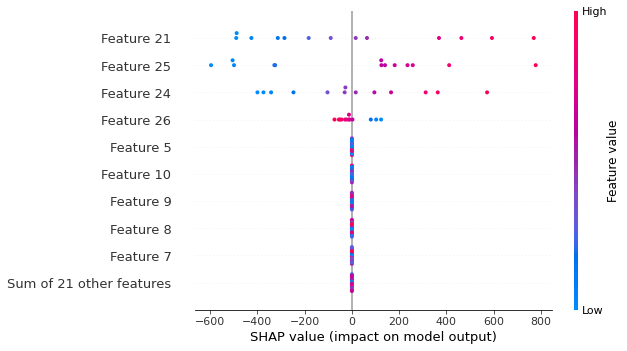

XIST_day14


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.366e+00, tolerance: 3.351e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.084e+01, tolerance: 3.351e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.135e+01, tolerance: 3.351e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.093e+01, tolerance: 3.351e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.039e+01, tolerance: 3.351e+00
Objective did n

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.690e+00, tolerance: 2.823e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.893e+00, tolerance: 2.823e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.499e+00, tolerance: 2.823e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.215e+00, tolerance: 2.823e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.968e+00, tolerance: 2.823e+00
Objective did n

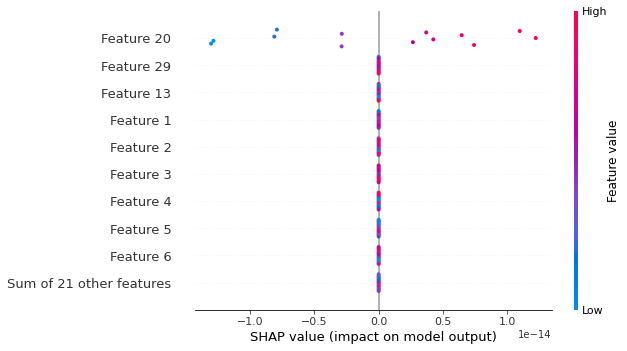

In [30]:
for task in rnaseq_tasks:
    
    print(task)

    # get the outcome vector 
    ctrain_outcome = train_outcomes[['subject_id', task]]
    
    # get the shared subjects 
    shared_subjects = set(ctrain_features.index.tolist()).intersection(ctrain_outcome.subject_id)
 
    # extract the shared subjects  
    xdata = ctrain_features.loc[ctrain_features.index.isin(shared_subjects)]
    ydata = ctrain_outcome.loc[ctrain_outcome.subject_id.isin(shared_subjects)]   
        
    # building the model
    lr_model = cmodel_function()
    lr_model.fit(xdata.values, ydata.iloc[:, 1].values)
    preds = lr_model.predict(ctest_features.values)
    
    
    # create the explanations 
    # explain the model's predictions using SHAP
    explainer = shap.explainers.Linear(lr_model, xdata.values)
    shap_values = explainer(xdata.values)
    shap.plots.beeswarm(shap_values)#, X_test_array, feature_names=vectorizer.get_feature_names())
    
    
    
    
    #     # create the ranks df
    #     ranks = [ctest_features.index.tolist(), np.argsort(preds)]
    #     ranks = list(zip(*ranks))
    #     ranks = pd.DataFrame(ranks, columns=['subject_id', 'rank'])
    #     test_preds[task] = ranks


In [145]:
test_preds.keys()

dict_keys(['IgG-PT_day14', 'IgG-FHA_day14', 'IgG-PRN_day14', 'Monocytes_day1', 'ASCs (Plasmablasts)_day7', 'CD4Tcells_day3', 'CCL3_day3', 'IL-6_day3', 'NFKBIA_day7', 'XIST_day14'])